Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.16 sold 2
0.53 sold 4
0.69 sold 2
0.88 sold 3
1.00 sold 3
1.01 sold 1
1.11 sold 3
1.44 sold 3
1.61 sold 2
1.97 sold 1
1.99 sold 4
1.99 placed order for 28
2.08 sold 2
2.38 sold 4
2.79 sold 4
3.11 sold 4
3.26 sold 4
3.28 sold 1
3.46 sold 2
3.99 received order, 29 in inventory
4.04 sold 4
4.06 sold 4
4.06 placed order for 29
4.12 sold 4
4.39 sold 1
4.56 sold 1
4.63 sold 2
4.82 sold 1
4.92 sold 1


Text(0, 0.5, 'Inventory level')

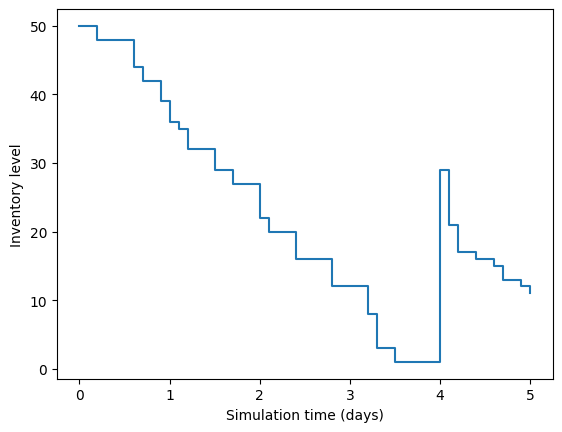

In [5]:
!pip install simpy                 # Instala el paquete "simpy" utilizando pip

import simpy                       # Importa la biblioteca simpy para simulaciones de eventos discretos
import numpy as np                 # Importa la biblioteca numpy para generación de números aleatorios
import matplotlib.pyplot as plt    # Importa la biblioteca matplotlib para graficar

# Definición de la función warehouse_run que representa la simulación del almacén
def warehouse_run(env, order_cutoff, order_target):
  global inventory, balance, num_ordered

  inventory = order_target           # Inicializa el inventario con el valor objetivo
  balance = 0.0                      # Inicializa el balance en 0.0
  num_ordered = 0                    # Inicializa el número de pedidos en 0

  while True:
    interarrival = generate_interarrival()       # Genera un tiempo de llegada entre pedidos
    yield env.timeout(interarrival)              # Espera hasta que llegue el próximo pedido
    balance -= inventory*2*interarrival          # Actualiza el balance restando el costo de almacenamiento
    demand = generate_demand()                    # Genera la demanda del producto
    if demand < inventory:
      balance += 100*demand                      # Actualiza el balance sumando el ingreso de ventas
      inventory -= demand                         # Actualiza el inventario restando la demanda
      print('{:.2f} sold {}'.format(env.now, demand))  # Imprime la cantidad vendida
    else:
      balance += 100*inventory                   # Actualiza el balance sumando el ingreso de ventas
      inventory = 0                              # Vacía el inventario
      print('{:.2f} sold {} (out of stock)'.format(env.now, inventory))  # Imprime que se agotó el stock
    if inventory < order_cutoff and num_ordered == 0:
      env.process(handle_order(env, order_target))   # Procesa el pedido si el inventario está por debajo del punto de reposición

# Definición de la función handle_order que representa el procesamiento de un pedido
def handle_order(env, order_target):
  global inventory, balance, num_ordered

  num_ordered = order_target - inventory   # Calcula la cantidad a pedir
  print('{:.2f} placed order for {}'.format(env.now, num_ordered))  # Imprime el pedido realizado
  balance -= 50*num_ordered                # Actualiza el balance restando el costo del pedido
  yield env.timeout(2.0)                   # Espera hasta que llegue el pedido
  inventory += num_ordered                  # Aumenta el inventario con el pedido recibido
  num_ordered = 0                           # Reinicia el contador de pedidos
  print('{:.2f} received order, {} in inventory'.format(env.now, inventory))  # Imprime el pedido recibido y el inventario actual

# Definición de la función generate_interarrival para generar el tiempo entre llegadas de pedidos
def generate_interarrival():
  return np.random.exponential(1./5)

# Definición de la función generate_demand para generar la demanda del producto
def generate_demand():
  return np.random.randint(1, 5)

obs_time = []           # Lista para almacenar los tiempos de observación
inventory_level = []    # Lista para almacenar los niveles de inventario

# Definición de la función observe para realizar las observaciones del inventario
def observe(env):
  global inventory

  while True:
    obs_time.append(env.now)                # Agrega el tiempo de observación a la lista
    inventory_level.append(inventory)       # Agrega el nivel de inventario a la lista
    yield env.timeout(0.1)                   # Espera un tiempo para realizar la siguiente observación

np.random.seed(0)      # Establece la semilla del generador de números aleatorios

env = simpy.Environment()        # Crea el entorno de simulación
env.process(warehouse_run(env, 25, 50))   # Agrega el proceso de simulación del almacén al entorno
env.process(observe(env))        # Agrega el proceso de observación al entorno

env.run(until = 5.0)    # Ejecuta la simulación hasta que el tiempo llegue a 5.0

# Grafica los resultados
plt.figure()
plt.step(obs_time, inventory_level, where='post')
plt.xlabel('Simulation time (days)')
plt.ylabel('Inventory level')
